In [1]:
# ============================
# 1. Imports & Paths
# ============================
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dataset path (direct, no augmentation)
data_dir = "//kaggle/input/cucumber-disease-augmented-dataset/Augmented Image"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# ============================
# 2. Dataset Setup
# ============================
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)
print("Classes:", class_names, "| Total Images:", len(dataset))


Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Gummy Stem Blight', 'Pythium Fruit Rot'] | Total Images: 6400


In [3]:
# ============================
# 3. Model Builder (Feature Extraction Only - Fixed)
# ============================
def build_model(num_classes):
    model = models.densenet169(weights="IMAGENET1K_V1")
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)

    # Freeze all pretrained layers
    for param in model.parameters():
        param.requires_grad = False

    # Ensure classifier is trainable
    for param in model.classifier.parameters():
        param.requires_grad = True

    return model.to(device)


In [4]:
# ============================
# 4. Training Function
# ============================
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=loss.item())
        train_loss = running_loss / total
        train_acc  = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_loss /= val_total
        val_acc = val_correct / val_total

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    return history


In [5]:

# ============================
# 5. Evaluation Function
# ============================
def evaluate_model(model, test_loader, class_names, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    print("\n=== Test Metrics ===")
    print(f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1 Score: {f1:.4f}")
    return acc, prec, rec, f1



===== Fold 1 / 3 =====


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 185MB/s]



Epoch 1/10


Epoch 1: Train Loss=1.6842, Train Acc=0.5241, Val Loss=1.3401, Val Acc=0.7296

Epoch 2/10


Epoch 2: Train Loss=1.1555, Train Acc=0.7907, Val Loss=0.9693, Val Acc=0.8210

Epoch 3/10


Epoch 3: Train Loss=0.8921, Train Acc=0.8385, Val Loss=0.7753, Val Acc=0.8622

Epoch 4/10


Epoch 4: Train Loss=0.7324, Train Acc=0.8659, Val Loss=0.6492, Val Acc=0.8622

Epoch 5/10


Epoch 5: Train Loss=0.6339, Train Acc=0.8767, Val Loss=0.5748, Val Acc=0.8749

Epoch 6/10


Epoch 6: Train Loss=0.5694, Train Acc=0.8830, Val Loss=0.5143, Val Acc=0.8791

Epoch 7/10


Epoch 7: Train Loss=0.5128, Train Acc=0.8856, Val Loss=0.4741, Val Acc=0.8828

Epoch 8/10


Epoch 8: Train Loss=0.4692, Train Acc=0.9001, Val Loss=0.4446, Val Acc=0.8852

Epoch 9/10


Epoch 9: Train Loss=0.4401, Train Acc=0.8985, Val Loss=0.4075, Val Acc=0.8941

Epoch 10/10


Epoch 10: Train Loss=0.4178, Train Acc=0.9037, Val Loss=0.3885, Val Acc=0.8960


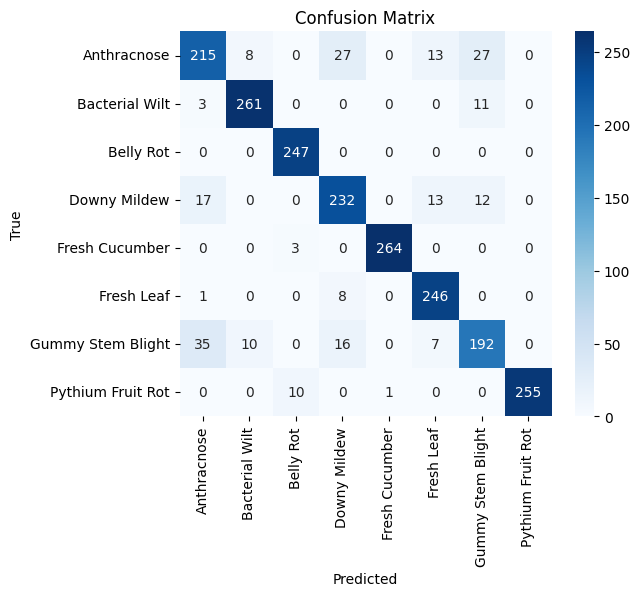


=== Test Metrics ===
Accuracy: 0.8960
Precision: 0.8962
Recall: 0.8985
F1 Score: 0.8967

===== Fold 2 / 3 =====

Epoch 1/10


Epoch 1: Train Loss=1.7064, Train Acc=0.4769, Val Loss=1.3608, Val Acc=0.6985

Epoch 2/10


Epoch 2: Train Loss=1.1799, Train Acc=0.7767, Val Loss=0.9884, Val Acc=0.8158

Epoch 3/10


Epoch 3: Train Loss=0.9058, Train Acc=0.8296, Val Loss=0.7986, Val Acc=0.8444

Epoch 4/10


Epoch 4: Train Loss=0.7519, Train Acc=0.8545, Val Loss=0.6690, Val Acc=0.8650

Epoch 5/10


Epoch 5: Train Loss=0.6457, Train Acc=0.8634, Val Loss=0.5866, Val Acc=0.8762

Epoch 6/10


Epoch 6: Train Loss=0.5772, Train Acc=0.8770, Val Loss=0.5244, Val Acc=0.8870

Epoch 7/10


Epoch 7: Train Loss=0.5198, Train Acc=0.8887, Val Loss=0.4820, Val Acc=0.8903

Epoch 8/10


Epoch 8: Train Loss=0.4716, Train Acc=0.8929, Val Loss=0.4463, Val Acc=0.8936

Epoch 9/10


Epoch 9: Train Loss=0.4468, Train Acc=0.8978, Val Loss=0.4212, Val Acc=0.8955

Epoch 10/10


Epoch 10: Train Loss=0.4142, Train Acc=0.9023, Val Loss=0.4011, Val Acc=0.8950


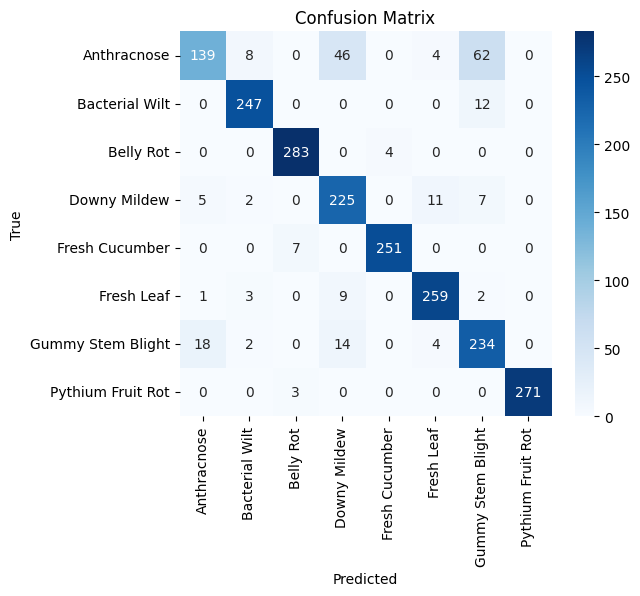


=== Test Metrics ===
Accuracy: 0.8950
Precision: 0.8976
Recall: 0.8930
F1 Score: 0.8895

===== Fold 3 / 3 =====

Epoch 1/10


Epoch 1: Train Loss=1.7065, Train Acc=0.4689, Val Loss=1.3384, Val Acc=0.7182

Epoch 2/10


Epoch 2: Train Loss=1.1776, Train Acc=0.7703, Val Loss=0.9659, Val Acc=0.8298

Epoch 3/10


Epoch 3: Train Loss=0.9054, Train Acc=0.8343, Val Loss=0.7772, Val Acc=0.8570

Epoch 4/10


Epoch 4: Train Loss=0.7526, Train Acc=0.8563, Val Loss=0.6533, Val Acc=0.8762

Epoch 5/10


Epoch 5: Train Loss=0.6385, Train Acc=0.8688, Val Loss=0.5725, Val Acc=0.8795

Epoch 6/10


Epoch 6: Train Loss=0.5692, Train Acc=0.8805, Val Loss=0.5086, Val Acc=0.8903

Epoch 7/10


Epoch 7: Train Loss=0.5234, Train Acc=0.8824, Val Loss=0.4625, Val Acc=0.8912

Epoch 8/10


Epoch 8: Train Loss=0.4796, Train Acc=0.8924, Val Loss=0.4295, Val Acc=0.8936

Epoch 9/10


Epoch 9: Train Loss=0.4466, Train Acc=0.8941, Val Loss=0.3989, Val Acc=0.9081

Epoch 10/10


Epoch 10: Train Loss=0.4242, Train Acc=0.8964, Val Loss=0.3749, Val Acc=0.9105


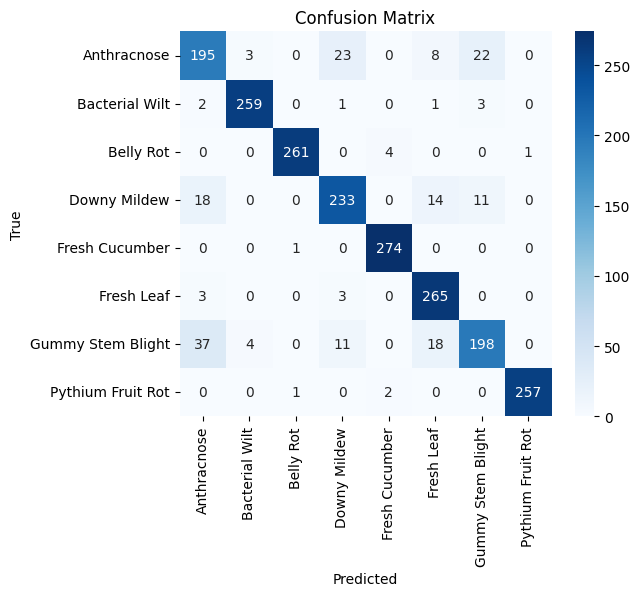


=== Test Metrics ===
Accuracy: 0.9105
Precision: 0.9097
Recall: 0.9097
F1 Score: 0.9088


In [6]:

# ============================
# 6. Cross Validation
# ============================
k_folds = 3
num_epochs = 10
batch_size = 32
results = {}
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# indices for dataset splitting
indices = list(range(len(dataset)))
class_names = dataset.classes   # make sure dataset is ImageFolder or has .classes

for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
    print(f"\n===== Fold {fold+1} / {k_folds} =====")
    train_sub = Subset(dataset, train_idx)
    val_sub   = Subset(dataset, val_idx)
    train_loader = DataLoader(train_sub, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_sub, batch_size=batch_size, shuffle=False, num_workers=2)

    model = build_model(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

    history = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device)
    acc, prec, rec, f1 = evaluate_model(model, val_loader, class_names, device)
    results[fold] = {"acc": acc, "prec": prec, "rec": rec, "f1": f1}


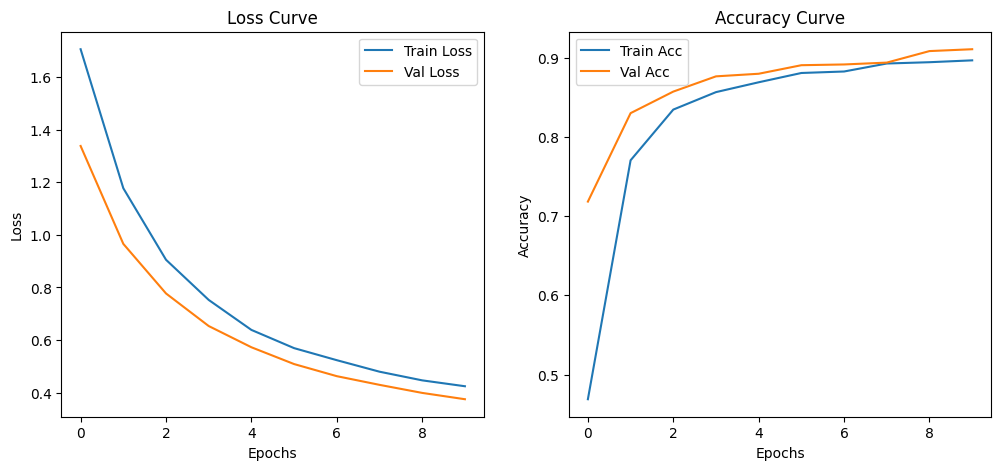

In [7]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy Curve")

plt.show()

In [8]:
# ============================
# 7. Average Metrics
# ============================
print("\n=== Cross Validation Results ===")
accs, precs, recs, f1s = [], [], [], []
for fold in results:
    print(f"Fold {fold+1}: {results[fold]}")
    accs.append(results[fold]["acc"])
    precs.append(results[fold]["prec"])
    recs.append(results[fold]["rec"])
    f1s.append(results[fold]["f1"])

print("\n=== Average Metrics Across Folds ===")
print(f"Accuracy: {np.mean(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f}")
print(f"Recall: {np.mean(recs):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")



=== Cross Validation Results ===
Fold 1: {'acc': 0.8959700093720713, 'prec': 0.8962456331708418, 'rec': 0.8984704537753179, 'f1': 0.8967220349076134}
Fold 2: {'acc': 0.8949835911861228, 'prec': 0.8976030007709914, 'rec': 0.8929848890202392, 'f1': 0.8895047606200881}
Fold 3: {'acc': 0.9104547585560244, 'prec': 0.9096783131945055, 'rec': 0.9096841838058671, 'f1': 0.9087720551276045}

=== Average Metrics Across Folds ===
Accuracy: 0.9005
Precision: 0.9012
Recall: 0.9004
F1 Score: 0.8983
